## DP기반 MPC제어

In [25]:
import numpy as np
from IPython.display import Image
import pdb
#
# [위치] F:\temp
# [venv] F:\venv\bento_yolo310\Scripts
# 동적계획법 이해: https://www.youtube.com/watch?v=0bqfTzpWySY
# 

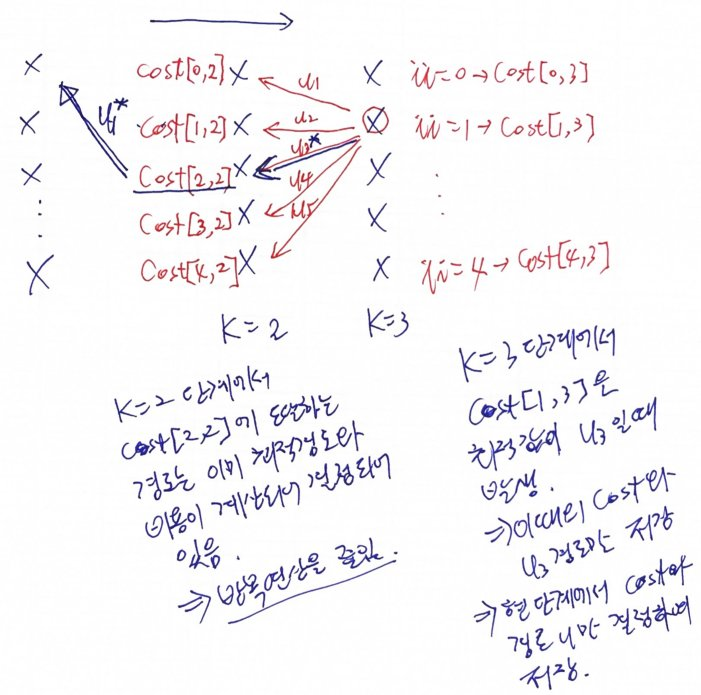

In [35]:
Image('dp요약.jpg')
# 만일 각 단계에서 이전 단계로 연결되는 경로의 최적값을 미리 계산하여 저장해 놓지 않으면,
# 탐색이 발생할 때 마다 후단의 모든 단계, 모든 경로를 재 탐색하여 다시 계산해야 한다.
# 이것은 과도하게 반복되는 계산을 발생시킴. DP는 이러한 반복연산을 LUT에 저장함에 의해 
# 제거 할 수 있음.
# LUT계산에는 현단계, 현노드에서 이전 단계로의 연결 중 최적연결을 선택(u*)하고, 이 연결과
# 그 때의 cost를 저장한다. 

In [23]:
## 시스템 매개변수
# 제어입력: -1 ~ +1, horizon: 5 ~ 10, 
# 초기상태: 0, 목표상태: 0.5
# 상태값범위: -2 ~ +2
##
N = 5  # 예측 구간
Q = 1  # 상태 가중치
R = 1  # 제어 입력 가중치
x0 = 0 #0  # 초기 상태
u_max = 1  # 제어 입력 범위
u_min = -1  # 제어 입력 범위
num_grid = 10  # 상태 및 제어 입력 격자 수

control_ref = 0.5  ###### 목표 상태값


# 상태와 제어 입력 공간 격자화
x_grid = np.linspace(-2, 2, num_grid)
u_grid = np.linspace(u_min, u_max, num_grid)
print(f"x:{x_grid}")
print(f"u:{u_grid}")

# 비용 함수 초기화
cost_to_go = np.inf * np.ones((num_grid, N+1))
cost_to_go[:, -1] = 0  # 종단 비용 초기화
print(cost_to_go[:,:])

# 최적 제어 입력 저장
u_optimal = np.zeros((num_grid, N))
u_step = np.zeros((num_grid, N))

# DP를 이용한 비용 함수 계산
for k in range(N-1, -1, -1):  # 단계순서는 뒤에서 앞으로
    # 각 단계마다 가능한 모든 x, u값을 순회함
    for ii, x in enumerate(x_grid):  # x값이 바뀜에 따라 아래 best의 u값이 선택되어도 cost값은 달라짐. 이 cost를 ii위치에 저장
        # 각 상태별로 최적의 u값 선택
        for jj, u in enumerate(u_grid):  # 주어진 x에 대해 u의 가능한 모든 값 중 cost가 최소가 되는 u를 선택하고, 그 때 cost값도 저장 
            x_next = x + u  # DNN: x_t+1=f(x_t,u_t)
            if x_next < x_grid[0] or x_next > x_grid[-1]:
                continue
            cost = (x-control_ref)**2 + u**2
            idx_next = np.argmin(np.abs(x_grid - x_next))  # 예측된 상태와 가능한 상태값 중 제일 가까운 값을 주는 인덱스
            # cost(k단계비용) + cost_to_go(k+1단계에서 (u로 결정된) 어떤 x에서의 cost)
            # cost_to_go[ii,kk]: 상태값 ii에서 k단계에서 종단까지 최적 비용의 합.
            # J(x_t)=min_u_t[c(x_t,u_t)+J(x_t+1)]: 현재 상태에서 미래에 도달할 목표까지 발생할 예상비용의 합
            total_cost = cost + cost_to_go[idx_next, k+1]
            
            # 현재의 ii(상태값), k(단계)에 대해 가능한 모든 u를 순회하여, 
            # 최소 비용을 주는 u값과 그 때의 cost를 LUT의 (ii,k)위치에 저장
            if total_cost < cost_to_go[ii, k]:
                cost_to_go[ii, k] = total_cost
                u_optimal[ii, k] = u
                u_step[ii, k] = jj
                #print(k,ii,jj,idx_next, x,u,cost,cost_to_go[idx_next, k+1],total_cost)

        print(f"step:{k}, state:{ii}, x:{x:.4f}, cost:{cost_to_go[ii,k]:.4f} ({u_optimal[ii, k]:.4f}, {int(u_step[ii, k])})")
        #pdb.set_trace()  # c누르면서 테스트
        
    print("----------------------")
                

# 초기 상태에 대한 최적 제어 입력 시퀀스 생성
x = x0
u_seq = []
for k in range(N):
    idx = np.argmin(np.abs(x_grid - x))
    u = u_optimal[idx, k]
    u_seq.append(u)
    x += u
    print(f"idx:{idx}, prev x:{x-u:.4f}, x:{x:.4f}, \
        u(indx):({u_grid[int(u_step[idx,k])]:.4f},{int(u_step[idx,k])}), \
        cost:{cost_to_go[idx,k]:.4f}")


# 결과 출력
print("Optimal control sequence:")
print(u_seq)

x:[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
  0.66666667  1.11111111  1.55555556  2.        ]
u:[-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]
[[inf inf inf inf inf  0.]
 [inf inf inf inf inf  0.]
 [inf inf inf inf inf  0.]
 [inf inf inf inf inf  0.]
 [inf inf inf inf inf  0.]
 [inf inf inf inf inf  0.]
 [inf inf inf inf inf  0.]
 [inf inf inf inf inf  0.]
 [inf inf inf inf inf  0.]
 [inf inf inf inf inf  0.]]
(10, 5) [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
step:4, state:0, x:-2.0000, cost:6.2623 (0.1111, 5)
step:4, state:1, x:-1.5556, cost:4.2377 (-0.1111, 4)
step:4, state:2, x:-1.1111, cost:2.6080 (-0.1111, 4)
step:4, state:3, x:-0.6667, cost:1.3735 (-0.1111, 4)
step:4, state:4, x:-0.2222, cost:0.5340 (-0.1111, 4)
step:4, state:5, x:0.2222, cost:0.0895 (-0.1111, 4)
step:4, state:6, x:0.6667, cost:0.0401 (-0.1111, 4)
step:4, state:7, x:1.1111, cost:0.3858 (-0.1111,

#### prev x값을 보면 0에서 출발하여 점차 목표 제어값인 0.5에 가까와 진다.  
#### cost_to_go 최적화루프의 해석  
- step:4, state:0, x:-2.0000, cost:6.2623 (0.1111, 5) 해석:
  - (x-ref)^2+u^2 = (-2-0.5)+0.1111^2 = 6.2623
- step:4, state:1, x:-1.5556, cost:4.2377 (-0.1111, 4) 해석:
  - (x-ref)^2+u^2 = (-1.5556-0.5)+(-0.1111)^2 = 4.2377
- step:3, state:0, x:-2.0000, cost:9.4630 (0.7778, 8) 해석:
  - (x-ref)^2+u^2 + cost_to_go[?,4] = (-2-0.5)+0.7778^2 + cost_to_go[2,4] = 9.4630
  - cost_to_go[?,4]: x+u = -2+0.7778 = -1.2222에 가까운 x의 index -> x_index=2
- step:3, state:3, x:-0.6667, cost:2.0062 (0.3333, 6) 해석: 
  - (x-ref)^2+u^2 + cost_to_go[?,4] = (-0.6667-0.5)+0.3333^2 + cost_to_go[4,4] = 2.0062
  - cost_to_go[?,4]: x+u = -0.6667+0.3333 = -0.3334에 가까운 x의 index -> x_index=4
#### 제어변수 u 결정부의 해석  
- idx:4, prev x:0.0000, x:0.3333, u(indx):(0.3333,6), cost:0.9414:
  - x0=0에 가까운 x의 index -> 4 -> u_optimal[4,0]=0.3333 -> x=x0+u=0+0.3333
- idx:5, prev x:0.3333, x:0.6667, u(indx):(0.3333,6), cost:0.3086:
  - x=0.3333에 가까운 x의 index -> 5 -> u_optimal[5,1]=0.3333 -> x=x+u=0.3333+0.3333=0.6667

In [10]:
# num_grid=20, N=5:
# step:4, x=0.2631578947368416(state step:10), u=0.05263157894736836(u step: 10)일 때 best cost가 나옴
print(x_grid,"\n", u_grid, )
cost_to_go_10_4 = (0.5-0.2631578947368416)*(0.5-0.2631578947368416) + 0.05263157894736836*0.05263157894736836 
print(cost_to_go_10_4)  # cost_to_go_ii_k

# step:3, x=0.2631578947368416(state step:10), u=0.05263157894736836(u step: 10)일 때 best cost가 나옴
cost_to_go_10_3 = (0.5-0.2631578947368416)*(0.5-0.2631578947368416) + 0.05263157894736836*0.05263157894736836 + cost_to_go_10_4
print(cost_to_go_10_3)

[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
  0.66666667  1.11111111  1.55555556  2.        ] 
 [-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]
0.058864265927978075
0.11772853185595615


In [ ]:
# 결과 설명: 
# 초기 상태값 x=0에서 출발하여 control_ref=0.5가 되도록 제어 입력 u를 조절하는 문제이다. 출력을 보면,
# x값은 0.306, 0.448, 0.428,... 등으로 점차 0.5에 접근함을 알 수 있다. 
# u값의 최적 sequence는 0.306, 0.1428, -0.02, ... 등으로 나오는데, x=0의 값을 0.5로 끌어 올리기 위해
# 초기에는 큰 u값이 가해지고 0.5에 가까워지면 0근처 값으로 줄어드는 결과가 나타난다. 
# 각 단계에서 cost는 첫 단계만 큰 값이 나오고(x값이 control_ref와 멀다) x가 5에 접근하면 0근처 값으로 떨어진다. 